In [1]:
import numpy as np
import pandas as pd
import os
from os import listdir
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import imutils

from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import Conv2D,Input,ZeroPadding2D,BatchNormalization,Flatten,Activation,Dense,MaxPooling2D
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle #shuffling the data improves the model

In [3]:
import cv2
import numpy as np
from os import listdir
from sklearn.utils import shuffle

def load_data(dir_list, image_size):

    # Load all images in the directories
    X = []
    y = []
    image_width, image_height = image_size

    for label, directory in enumerate(dir_list, start=1):
        for filename in listdir(directory):
            image = cv2.imread(directory+'/'+filename)
            image = crop_brain_contour(image, plot=False)
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # Normalize values
            image = image / 255.
            # Convert image to a numpy array and append it to X
            X.append(image)
            # Append the corresponding label to y
            y.append(label)

    X = np.array(X)
    y = np.array(y)

    # Shuffle the data
    X, y = shuffle(X, y)

    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')

    return X, y


In [4]:
pit = r'C:\Users\gfox6\Downloads\archive\Training\pituitary'
men = r'C:\Users\gfox6\Downloads\archive\Training\meningioma'
notu = r'C:\Users\gfox6\Downloads\archive\Training\notumor'
gli = r'C:\Users\gfox6\Downloads\archive\Training\glioma'

IMG_WIDTH, IMG_HEIGHT = (240, 240)

X, y = load_data([gli, men, notu, pit], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 5712
X shape is: (5712, 240, 240, 3)
y shape is: (5712,)


In [150]:
X1=X[:1000]
y1=y[:1000]

In [151]:
def split_data(X, y, test_size=0.2):
       
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [152]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X1, y1, test_size=0.3)

In [153]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of validation examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))

number of training examples = 700
number of validation examples = 150
number of test examples = 150


In [154]:
def build_model(input_shape, num_classes=5):
    X_input = Input(input_shape)
    X = ZeroPadding2D((2, 2))(X_input)

    X = Conv2D(32, (7, 7), strides=(1, 1))(X)
    X = BatchNormalization(axis=3, name='bn0')(X)
    X = Activation('relu')(X)

    X = MaxPooling2D((4, 4))(X)
    X = MaxPooling2D((4, 4))(X)
    X = Flatten()(X)
    X = Dense(num_classes, activation='softmax')(X)  # Use softmax activation for multi-class classification
    model = Model(inputs=X_input, outputs=X)

    return model

IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)
model = build_model(IMG_SHAPE, num_classes=5)
model.summary()


Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 zero_padding2d_5 (ZeroPadd  (None, 244, 244, 3)       0         
 ing2D)                                                          
                                                                 
 conv2d_5 (Conv2D)           (None, 238, 238, 32)      4736      
                                                                 
 bn0 (BatchNormalization)    (None, 238, 238, 32)      128       
                                                                 
 activation_5 (Activation)   (None, 238, 238, 32)      0         
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 59, 59, 32)        0         
 ng2D)                                                     

In [155]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [156]:
model.fit(x=X_train, y=y_train, batch_size=5, epochs=15, validation_data=(X_val, y_val))

Epoch 1/15
140/140 [==============================] - 31s 214ms/step - loss: 1.6229 - accuracy: 0.5400 - val_loss: 1.2753 - val_accuracy: 0.5267
Epoch 2/15
140/140 [==============================] - 27s 194ms/step - loss: 0.9417 - accuracy: 0.7014 - val_loss: 1.0270 - val_accuracy: 0.7000
Epoch 3/15
140/140 [==============================] - 27s 194ms/step - loss: 1.0466 - accuracy: 0.7100 - val_loss: 1.7566 - val_accuracy: 0.6467
Epoch 4/15
140/140 [==============================] - 28s 201ms/step - loss: 0.7832 - accuracy: 0.7714 - val_loss: 1.2070 - val_accuracy: 0.7333
Epoch 5/15
140/140 [==============================] - 27s 194ms/step - loss: 0.5793 - accuracy: 0.8043 - val_loss: 1.3188 - val_accuracy: 0.6600
Epoch 6/15
140/140 [==============================] - 27s 193ms/step - loss: 0.5111 - accuracy: 0.8214 - val_loss: 1.3652 - val_accuracy: 0.7067
Epoch 7/15
140/140 [==============================] - 27s 192ms/step - loss: 0.5146 - accuracy: 0.8271 - val_loss: 1.3358 - val_ac

In [157]:
history = model.history.history

In [158]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

In [159]:
#test_labels = test_batches.classes
predictions = model.predict(x=X_test, steps=len(y_test), verbose=0)
cm = confusion_matrix(y_true=y_test, y_pred=predictions.argmax(axis=1))

In [160]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[41 10  1  5]
 [ 4 38  2  2]
 [ 0  5 55  0]
 [ 3  5  3 51]]


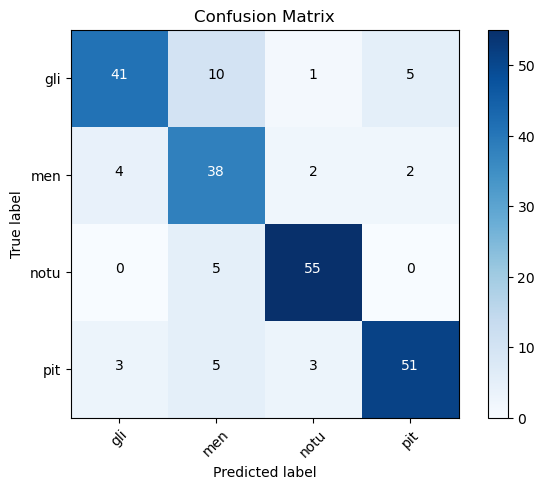

In [134]:
import itertools
cm_plot_labels = ['gli', 'men', 'notu', 'pit']
plot_confusion_matrix(cm=cm, classes= cm_plot_labels , title='Confusion Matrix')

In [161]:
from sklearn.metrics import classification_report 
print(classification_report(y_test,predictions.argmax(axis=1)))
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test,predictions.argmax(axis=1)))

              precision    recall  f1-score   support

           1       0.65      0.59      0.62        34
           2       1.00      0.36      0.53        33
           3       0.92      0.98      0.95        48
           4       0.62      1.00      0.77        35

    accuracy                           0.76       150
   macro avg       0.80      0.73      0.72       150
weighted avg       0.81      0.76      0.74       150



In [162]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test,predictions.argmax(axis=1)))

0.76


In [163]:
#test_labels = test_batches.classes
predictions = model.predict(x=X_train, steps=len(y_train), verbose=0)
cm = confusion_matrix(y_true=y_train, y_pred=predictions.argmax(axis=1))

Confusion matrix, without normalization
[[151   0   1  22]
 [ 13  97  14  25]
 [  0   0 193   0]
 [  0   0   0 184]]


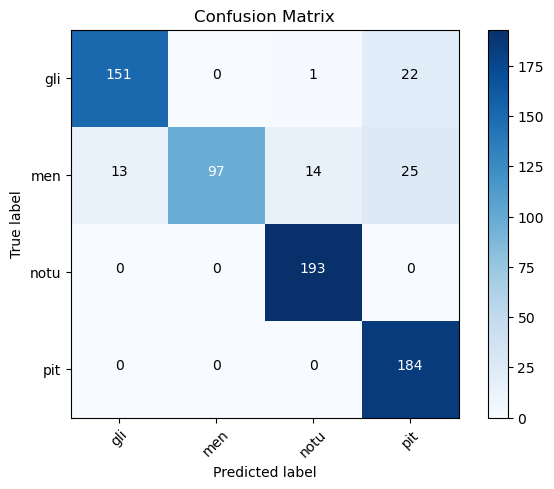

In [164]:
import itertools
cm_plot_labels = ['gli', 'men', 'notu', 'pit']
plot_confusion_matrix(cm=cm, classes= cm_plot_labels , title='Confusion Matrix')

In [165]:
from sklearn.metrics import classification_report 
print(classification_report(y_train,predictions.argmax(axis=1)))

              precision    recall  f1-score   support

           1       0.92      0.87      0.89       174
           2       1.00      0.65      0.79       149
           3       0.93      1.00      0.96       193
           4       0.80      1.00      0.89       184

    accuracy                           0.89       700
   macro avg       0.91      0.88      0.88       700
weighted avg       0.91      0.89      0.89       700



In [182]:
import os.path
#model.save('braintumor1000.h5')
from tensorflow.keras.models import load_model
new_model=load_model('braintumor1500.h5')
new_model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 zero_padding2d_4 (ZeroPadd  (None, 244, 244, 3)       0         
 ing2D)                                                          
                                                                 
 conv2d_4 (Conv2D)           (None, 238, 238, 32)      4736      
                                                                 
 bn0 (BatchNormalization)    (None, 238, 238, 32)      128       
                                                                 
 activation_4 (Activation)   (None, 238, 238, 32)      0         
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 59, 59, 32)        0         
 g2D)                                                      

In [183]:
new_model.get_weights()

[array([[[[-3.02328467e-02, -1.16962896e-04,  6.13968782e-02, ...,
            6.91727847e-02, -6.24278970e-02,  7.81736597e-02],
          [-1.05529036e-02,  2.97260024e-02,  1.06561489e-01, ...,
            2.17085592e-02, -4.99042980e-02, -3.15286452e-03],
          [-2.60860082e-02, -5.45336772e-03,  7.66401589e-02, ...,
            4.67852280e-02, -1.09574357e-02,  4.43873517e-02]],
 
         [[-2.57380828e-02,  8.54150951e-02, -2.04119775e-02, ...,
            2.41969042e-02,  3.19078006e-02,  3.84696350e-02],
          [-4.01921496e-02,  6.40914291e-02, -3.11410800e-03, ...,
            3.46377194e-02, -1.07183326e-02,  5.45171238e-02],
          [ 2.56082695e-02,  7.63891079e-03,  1.85120795e-02, ...,
            1.76648237e-02,  6.98103709e-03,  2.64725480e-02]],
 
         [[ 1.10294968e-02,  1.05077364e-01,  3.49822640e-02, ...,
           -2.57025454e-02, -1.37478273e-04,  6.59300685e-02],
          [-6.17296398e-02,  8.93790722e-02, -7.67733000e-05, ...,
            2.280

In [184]:
new_model.optimizer

Confusion matrix, without normalization
[[20  0  2 12]
 [11 12  2  8]
 [ 0  0 47  1]
 [ 0  0  0 35]]


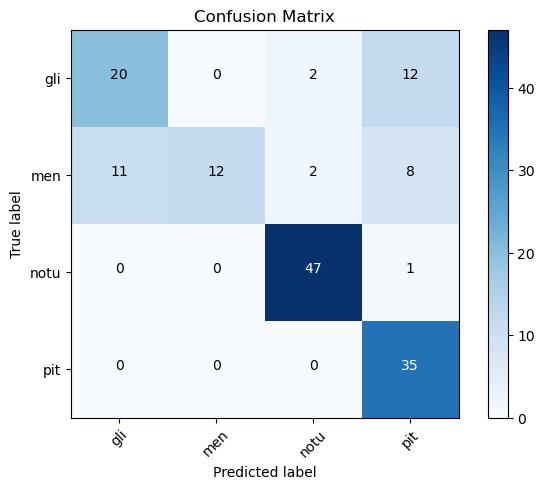

In [190]:
predictions = model.predict(x=X_test, steps=len(y_test), verbose=0)
cm = confusion_matrix(y_true=y_test, y_pred=predictions.argmax(axis=1))
cm_plot_labels = ['gli', 'men', 'notu', 'pit']
plot_confusion_matrix(cm=cm, classes= cm_plot_labels , title='Confusion Matrix')

In [186]:
from sklearn.metrics import classification_report 
print(classification_report(y_test,predictions.argmax(axis=1)))
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test,predictions.argmax(axis=1)))

              precision    recall  f1-score   support

           1       0.94      0.88      0.91        34
           2       0.85      1.00      0.92        33
           3       1.00      0.96      0.98        48
           4       0.97      0.91      0.94        35

    accuracy                           0.94       150
   macro avg       0.94      0.94      0.94       150
weighted avg       0.94      0.94      0.94       150

0.94


In [191]:
!pip install FastAPI

  Obtaining dependency information for FastAPI from https://files.pythonhosted.org/packages/f3/4f/0ce34195b63240b6693086496c9bab4ef23999112184399a3e88854c7674/fastapi-0.104.1-py3-none-any.whl.metadata
  Obtaining dependency information for anyio<4.0.0,>=3.7.1 from https://files.pythonhosted.org/packages/19/24/44299477fe7dcc9cb58d0a57d5a7588d6af2ff403fdd2d47a246c91a3246/anyio-3.7.1-py3-none-any.whl.metadata
  Obtaining dependency information for starlette<0.28.0,>=0.27.0 from https://files.pythonhosted.org/packages/58/f8/e2cca22387965584a409795913b774235752be4176d276714e15e1a58884/starlette-0.27.0-py3-none-any.whl.metadata
  Obtaining dependency information for typing-extensions>=4.8.0 from https://files.pythonhosted.org/packages/24/21/7d397a4b7934ff4028987914ac1044d3b7d52712f30e2ac7a2ae5bc86dd0/typing_extensions-4.8.0-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/92.9 kB ? eta -:--:--
   ---------------------------------------- 92.9/92.9 kB 2.6 MB/s eta 0:00